Example 1

Finite $\mathcal H$

In [47]:
import os
import numpy as np
from PIL import Image

# Define the directories
duck_dir = 'Data/DuckImages/Ducks'
cow_dir = 'Data/DuckImages/Cows'

# Function to load and preprocess images
def load_and_preprocess_images(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.webp'):
            image_path = os.path.join(directory, filename)
            image = Image.open(image_path).convert('RGB')
            image = image.resize((32, 32))
            image = np.array(image).astype(np.float32)
            image = image / 255.0  # Normalize to [0, 1]
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load and preprocess images
cow_images, cow_labels = load_and_preprocess_images(cow_dir, 0)
duck_images, duck_labels = load_and_preprocess_images(duck_dir, 1)

In [48]:
yellow = np.array([1.0, 1.0, 0])
yellow = yellow / np.linalg.norm(yellow)
print(yellow)

[0.70710678 0.70710678 0.        ]


In [54]:
def yellow_score(im):
    c = im.mean(axis=(0,1))
    c = c / np.linalg.norm(c)
    return (c*yellow).sum()

def h_duck(im, scale):
    return yellow_score(im) >= scale

hypotheses = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

def eval_h(s):
    n=0
    corrects = 0
    for im in duck_images:
        n+=1
        is_duck = h_duck(im, s)
        if is_duck:
            corrects += 1
        
    for im in cow_images:
        n+=1
        is_duck = h_duck(im, s)
        if not is_duck:
            corrects += 1
    
    return corrects, n

for h in hypotheses:
    c, n = eval_h(h)
    print(f"Hypothesis with score threshold {h}: {c} corrects, {c/n:.2f}")


Hypothesis with score threshold 0: 19 corrects, 0.56
Hypothesis with score threshold 0.1: 19 corrects, 0.56
Hypothesis with score threshold 0.2: 19 corrects, 0.56
Hypothesis with score threshold 0.3: 19 corrects, 0.56
Hypothesis with score threshold 0.4: 19 corrects, 0.56
Hypothesis with score threshold 0.5: 19 corrects, 0.56
Hypothesis with score threshold 0.6: 19 corrects, 0.56
Hypothesis with score threshold 0.7: 19 corrects, 0.56
Hypothesis with score threshold 0.8: 20 corrects, 0.59
Hypothesis with score threshold 0.85: 26 corrects, 0.76
Hypothesis with score threshold 0.9: 26 corrects, 0.76
Hypothesis with score threshold 0.95: 15 corrects, 0.44
Hypothesis with score threshold 1.0: 15 corrects, 0.44


Example 2

Randomly choosing hypothesis CAN work.

In [42]:
import numpy as np
from sklearn.datasets import load_iris

# Load the iris dataset
iris = load_iris()
X, y = iris.data, iris.target
X = X[:100, :2]
X = X - np.mean(X, axis=0)
y = (y[:100]-0.5)*2

# Define the perceptron model in 2 steps
# 1. compute the linear (affine, the term is discussed later) score
def f_pre(X, w0, w1, b): # pre for pre-activation
    return w0*X[:, 0] + w1*X[:, 1] + b

# 2. define what to do with the score
def f_act(s):
    return 1/(np.exp(-s)+1)

def ce_loss(p, ytrue):
    e = - np.log( np.maximum(p[ytrue>0], 1e-9) ) \
        - np.log( np.maximum(1-p[ytrue<=0], 1e-9) )
    return e.mean()

rng = np.random.RandomState(42)
perceptrons = (rng.rand(100, 2) - 0.5) * 2

losses = []
for w in perceptrons:
    losses.append(ce_loss(f_act(f_pre(X, w[0], w[1], 0)), y))
losses=np.array(losses)



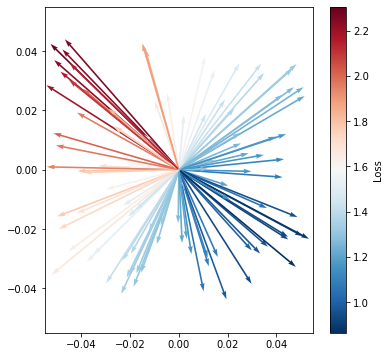

In [43]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as mcolorbar
import matplotlib.colors as mcolors

norm = mcolors.Normalize(vmin=losses.min(), vmax=losses.max())
colormap = cm.ScalarMappable(norm=norm, cmap=cm.RdBu_r)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
C=ax.quiver(np.zeros(100), np.zeros(100), 
            perceptrons[:, 0], 
            perceptrons[:, 1], color=cm.RdBu_r(norm(losses)), scale=2.0)
cbar = fig.colorbar(colormap, ax=ax)
cbar.set_label('Loss')

Can you select the hypothesis according to the losses?

Example 3

Curse of dimension

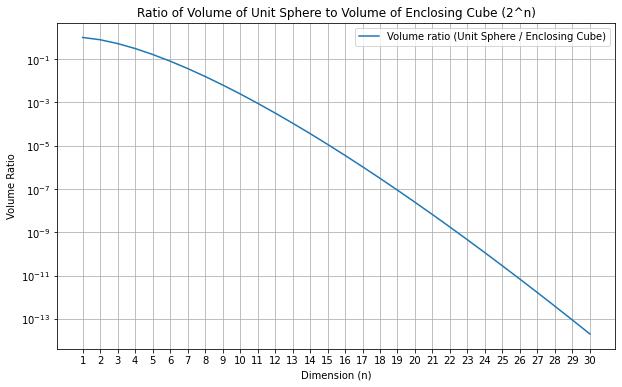

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

# Function to compute the volume of an n-dimensional unit sphere
def unit_sphere_volume(n):
    return (np.pi**(n/2)) / gamma(n/2 + 1)

# Dimensions from 1 to 100
dimensions = np.arange(1, 31)

# Calculate volumes and ratios
sphere_volumes = np.array([unit_sphere_volume(n) for n in dimensions])
cube_volumes = np.power(2.0, dimensions)
ratios = sphere_volumes / cube_volumes

# Plot the ratios
plt.figure(figsize=(10, 6))
plt.semilogy(dimensions, ratios, label='Volume ratio (Unit Sphere / Enclosing Cube)')
plt.xticks(dimensions)
plt.xlabel('Dimension (n)')
plt.ylabel('Volume Ratio')
plt.title('Ratio of Volume of Unit Sphere to Volume of Enclosing Cube (2^n)')
plt.legend()
plt.grid(True)
plt.show()


Example 4

Perceptron training

In [130]:
from sklearn.datasets import load_iris

# Load the iris dataset
iris = load_iris()
X, y = iris.data, iris.target
X = X[:100, :2]
X = X - np.mean(X, axis=0)
y = (y[:100]-0.5)*2

def h(X, w0, w1):
    return np.sign(w0*X[:, 0] + w1*X[:, 1])

xgrid, ygrid = np.meshgrid(np.linspace(-1.2, 1.6, 20), np.linspace(-1.2, 1.2, 20))
gridsamples = np.stack([xgrid.flatten(), ygrid.flatten()]).T

rng = np.random.RandomState(42)

def plot_model_with_random_error(w, ax):
    w0, w1 = w
    gridpred = h(gridsamples, w0, w1)
    errind = h(X, w0, w1) != y
    ax.scatter(X[:,0], X[:, 1], c=y)
    ax.plot(gridsamples[gridpred>0, 0], gridsamples[gridpred>0, 1], 
           color=[1, 1, 0, 0.2], marker='s', markersize=8, linestyle='')
    ax.plot(gridsamples[gridpred<0, 0], gridsamples[gridpred<0, 1], 
           color=[1, 0, 1, 0.2], marker='s', markersize=8, linestyle='')
    ax.plot(X[errind, 0], X[errind, 1], color='r', linestyle='', marker='x')
    ax.set_title(f"Error count: {errind.sum():d}")
    ax.quiver([0], [0], [w0], [w1], color="b", scale=1.0, scale_units='xy')
    ii = np.nonzero(errind)[0]
    if len(ii) > 0:
        i_ = rng.randint(low=0, high=len(ii))
        i = ii[i_]
        ret = X[i], y[i]
        ax.quiver([0], [0], X[i,0], X[i,1], color="r", scale=1.0, scale_units='xy')
    else:
        ret = None, None
    return ret


w_init = np.array([0.5, 0.3])
w = w_init

[-0.371  0.701]


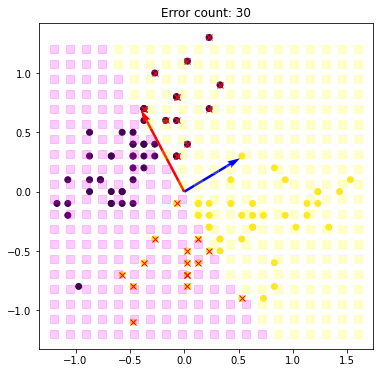

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
xerr, yerr = plot_model_with_random_error(w, ax)
print(xerr)

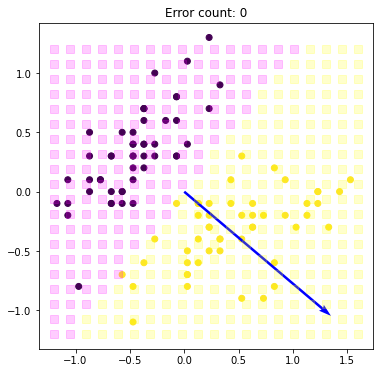

In [139]:
if xerr is not None:
    w = w + xerr*yerr

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
xerr, yerr = plot_model_with_random_error(w, ax)

Example 5

Compute the gradient and follow the *negative* gradient direction to find good
set of parameters.

The ChatGPT prompt to generate the major part of the graident computation code is

====

I defined a perceptron model for a simplified problem of Iris flowers:
```
import numpy as np
from sklearn.datasets import load_iris

# Load the iris dataset
iris = load_iris()
X, y = iris.data, iris.target
X = X[:100, :2]
X = X - np.mean(X, axis=0)
y = (y[:100]-0.5)*2

# Define the perceptron model in 2 steps
# 1. compute the linear (affine, the term is discussed later) score
def f_pre(X, w0, w1, b): # pre for pre-activation
    return w0*X[:, 0] + w1*X[:, 1] + b

# 2. define what to do with the score
def f_act(s):
    return 1/(np.exp(-s)+1)

def cross_entropy_loss(p, ytrue):
    e = - np.log( np.maximum(p[ytrue>0], 1e-9) ) \
        - np.log( np.maximum(1-p[ytrue<=0], 1e-9) )
    return e.mean()
```
Let us keep b=0, initialise w0=0.5, w1=0.3. Help me implement a gradient computation:
`def grad_w(w, X, y)`, which computes how small change in w will affect cross_entropy_loss(f_act(f_pre(X, w[0], w[1], b=0)), y).




In [155]:
import numpy as np
from sklearn.datasets import load_iris

# Load the iris dataset
iris = load_iris()
X, y = iris.data, iris.target
X = X[:100, :2]
X = X - np.mean(X, axis=0)
y = (y[:100]-0.5)*2

# Define the perceptron model in 2 steps
# 1. compute the linear (affine, the term is discussed later) score
def f_pre(X, w0, w1, b): # pre for pre-activation
    return w0*X[:, 0] + w1*X[:, 1] + b

# 2. define what to do with the score
def f_act(s):
    return 1/(np.exp(-s)+1)

def ce_loss(p, ytrue):
    e = - np.log( np.maximum(p[ytrue>0], 1e-9) ) \
        - np.log( np.maximum(1-p[ytrue<=0], 1e-9) )
    return e.mean()

In [166]:
weight_decay=0.1
def grad_w(w, X, y):
    w0, w1 = w
    s = f_pre(X, w0, w1, 0)
    p = f_act(s)

    # Compute the gradient of the cross-entropy loss with respect to the pre-activation score
    ## KEY COMPUTATION ##
    grad_loss_p = - (y / np.maximum(p, 1e-9)) + ((1 - y) / np.maximum(1 - p, 1e-9))
    grad_p_s = p * (1 - p)

    grad_loss_s = grad_loss_p * grad_p_s

    # Compute the gradient of the pre-activation score with respect to the weights
    grad_s_w0 = X[:, 0]
    grad_s_w1 = X[:, 1]

    # Apply the chain rule to find the gradient of the loss with respect to the weights
    grad_w0 = np.mean(grad_loss_s * grad_s_w0) + w0*weight_decay
    grad_w1 = np.mean(grad_loss_s * grad_s_w1) + w1*weight_decay

    return np.array([grad_w0, grad_w1])

# Initialize weights
w = np.array([0.5, 0.3])

# Compute the gradient
gradient = grad_w(w, X, y)
print("Gradient:", gradient)


Gradient: [-0.36975497  0.36798614]


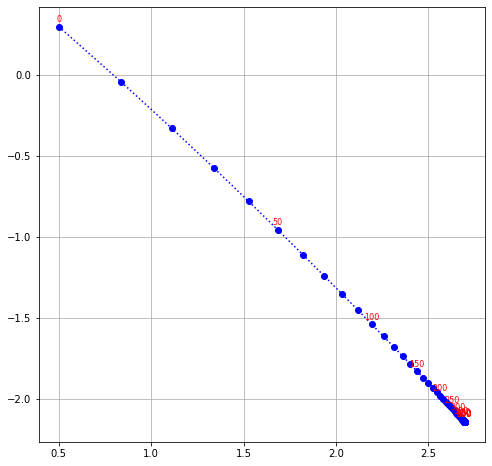

In [167]:
ws = [w]
for i in range(600):
    w = w - gradient * 0.1
    gradient = grad_w(w, X, y)
    ws.append(w.copy())

ws = np.array(ws)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(ws[::10, 0], ws[::10, 1], 'bo:')
ax.grid('on')

# Add annotations for time steps
for i in range(0, len(ws), 50):
    ax.annotate(f'{i}', (ws[i, 0], ws[i, 1]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='red')

plt.show()

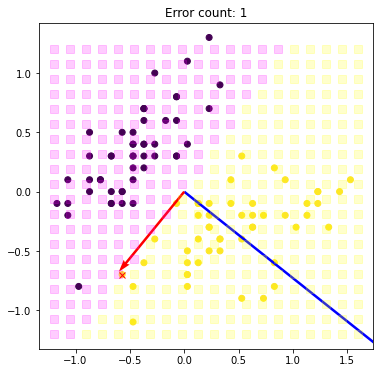

In [162]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
xerr, yerr = plot_model_with_random_error(w, ax)

Example Gradient Descent in Nonlinear Models

The model is 

$
f(X; w) = w_1 \cos(X_1) + w_2 X_2^2
$

tensor([0.3367, 0.1288], requires_grad=True)


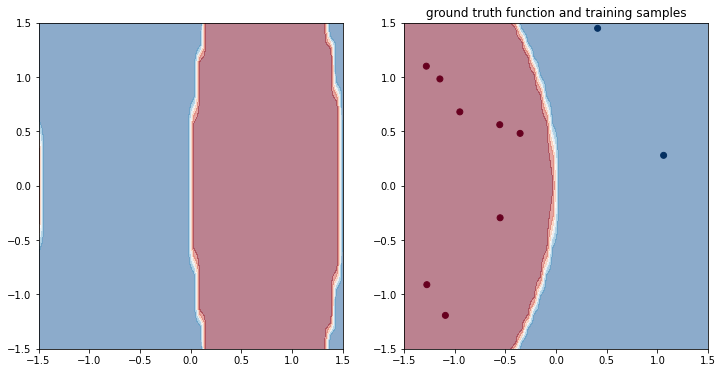

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def model1(w, X):
    return torch.sin(w[0] * X[:, 0] * 3.14 * 2.0  ) \
        -  w[1] * (X[:, 1] ** 2)

# Make a data space grid sample for viz
XBND = 1.5
xx0, xx1 = np.meshgrid(np.linspace(-XBND, XBND, 50), np.linspace(-XBND, XBND, 50))
X_grid = torch.Tensor(np.stack([xx0.flatten(), xx1.flatten()]).T).to(torch.float32)

# Sample initial W and A "true model", then sample some data samples from the true model
torch.manual_seed(42)
w_init = torch.randn(size=(2,), requires_grad=True) # model parameter, 
    # needs to keep grad for optimisation
torch.manual_seed(123)
w_gnd = torch.randn(size=(2,))
N = 100
beta = 100
X = torch.rand(size=(N, 2)) * 2 * XBND - XBND
to_prob = lambda s:torch.sigmoid(s*beta)
y = (torch.rand(size=(N,)) < to_prob(model1(w_gnd, X))).to(torch.int64)

print(w_init)

VIS_W_INIT = True
if VIS_W_INIT:
    s = to_prob(model1(w_init, X_grid)).detach().numpy()

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].contourf(xx0, xx1, s.reshape(xx0.shape), cmap="RdBu_r", vmin=0, vmax=1,
                    alpha=0.5)
    s = to_prob(model1(w_gnd, X_grid)).detach().numpy()
    axs[1].contourf(xx0, xx1, s.reshape(xx0.shape), cmap="RdBu_r", vmin=0, vmax=1,
                    alpha=0.5)
    axs[1].scatter(X[:,0], X[:,1], c=y, cmap="RdBu_r", vmin=0, vmax=1)
    axs[1].set_title("ground truth function and training samples")




In [ ]:
to_prob(model1(w_gnd, X)), model1(w_gnd, X)

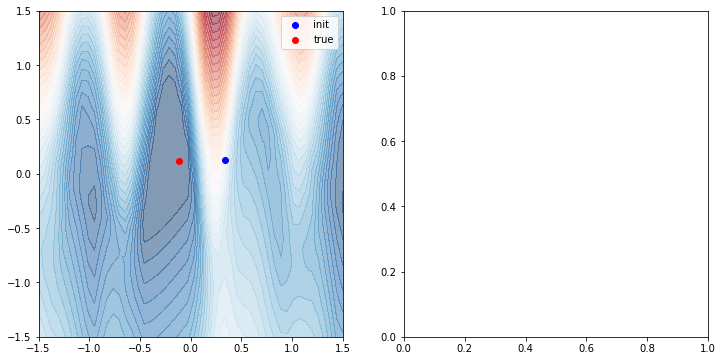

In [12]:
# Compute training error for w
def loss_fn(model_fn, w, X_trn, y_trn,  beta):
    s = beta * model_fn(w, X_trn)
    s = torch.stack([torch.zeros_like(s), s], dim=1)
    return nn.CrossEntropyLoss()(s, y_trn)
# loss_fn(model1, w_init, X_trn=X, y_trn=y, beta=beta)

# Check the terrain in W-domain
WBND = 1.0
ww0, ww1 = np.meshgrid(np.linspace(-XBND, XBND, 50), np.linspace(-XBND, XBND, 50))
W_grid = torch.Tensor(np.stack([ww0.flatten(), ww1.flatten()]).T).to(torch.float32)

loss_distri = np.array([
    loss_fn(model1, w_, X, y, beta).detach().item() for w_ in W_grid
])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].contourf(ww0, ww1, loss_distri.reshape(ww0.shape), levels=50,
                cmap="RdBu_r", #vmin=0, vmax=1,
                alpha=0.5)
axs[0].scatter([w_init[0].detach()], [w_init[1].detach()], color=[0, 0, 1], label="init")
axs[0].scatter([w_gnd[0]], [w_gnd[1]], color=[1, 0, 0], label="true")
axs[0].legend()